In [1]:
# Let's create a shapes dataset. We will start extremely simple, we will have circles and squares, and they can be blue or red. We will have slots 
# attend to a shape and then predict a) what the shape is, and b) what the color is. Baseline is random guess for each. 

# 1. Make sure slot attention module is correct (based on both PyTorch and TF githubs) DONE
# 2. Make sure encoder is correct (based on both PyTorch and TF githubs)

# ... learn how to use PyTorch Lightning, try quantization 

In [555]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from typing import List 
import random
import math 
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn.init as init
from typing import Callable, Optional, Tuple
import os
import h5py
from torchvision import transforms
import pytorch_lightning as pl
import pickle

In [556]:
class ShapeType(Enum):
    CIRCLE = "Circle"
    SQUARE = "Square"

class ColorType(Enum):
    RED = [255, 0, 0]
    BLUE = [0, 0, 255]

@dataclass(frozen=True)
class Shape: 
    shape_type: ShapeType
    color: ColorType 
    center: List[int]
    

@dataclass(frozen=True)
class ImageData:
    circle: Shape
    square: Shape

In [557]:
RADIUS = 5
IMAGE_SIZE = 30
DATASET_SIZE = 500
assert 2*RADIUS < IMAGE_SIZE

In [558]:
def create_random_shape_image(image_size: int, radius: int) -> np.ndarray:
    """Create random shape mask"""
    assert 2*radius < image_size
    
    # Create a blank grey image (using 3 channels for RGB)
    image = np.ones((image_size, image_size, 3), dtype=np.uint8) * 200  # Grey background

    # Choose two random centers from a grid of possible values
    grid_values = [i*RADIUS for i in range(1, IMAGE_SIZE//RADIUS)]
    x1, y1, x2, y2 = random.sample(range(len(grid_values)), 4)
    center_1 = [grid_values[x1], grid_values[y1]]
    center_2 = [grid_values[x2], grid_values[y2]]

    # Choose random colors
    color_1 = COLORS[random.randint(0, len(COLORS) - 1)]
    color_2 = COLORS[random.randint(0, len(COLORS) - 1)]
    
    # Create a grid of pixel coordinates
    y, x = np.ogrid[:image_size, :image_size]  

    # Construct circle mask 
    distance_from_center = (x - center_1[0])**2 + (y - center_1[1])**2  # Euclidean distance squared
    mask = distance_from_center <= radius**2  # Circle condition
    image[mask] = color_1.value

    # Construct square maks
    mask = (((x >= center_2[0] - radius) * (x <= center_2[0] + radius)) * ((y >= center_2[0] - radius) * (y <= center_2[0] + radius)))
    image[mask] = color_2.value  
    
    return image

In [559]:
def create_two_shape_dataset(image_size: int, radius: int, dataset_size: int) -> List[ImageData]:
    image_data = []

    for _ in range(dataset_size): 
        # Choose two random centers from a grid of possible values
        grid_values = [i*RADIUS for i in range(1, IMAGE_SIZE//RADIUS)]
        x1, y1, x2, y2 = random.sample(range(len(grid_values)), 4)
        center_1 = [grid_values[x1], grid_values[y1]]
        center_2 = [grid_values[x2], grid_values[y2]]
    
        # Choose random colors
        color_1, color_2 = random.choices([x for x in ColorType], k=2)
    
        circle = Shape(shape_type=ShapeType.CIRCLE, color=random.choice([x for x in ColorType]), center=center_1)
        square = Shape(shape_type=ShapeType.SQUARE, color=random.choice([x for x in ColorType]), center=center_2)
    
        image_data.append(ImageData(circle=circle, square=square))

    return image_data

In [560]:
class ShapeDataset(Dataset):
    def __init__(self, image_size: int, radius: int, dataset_size: int):
        self.image_size = image_size
        self.radius = radius
        self.dataset_size = dataset_size
        self.data = create_two_shape_dataset(self.image_size, self.radius, self.dataset_size)

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single sample (features and label) by index
        image_data = self.data[idx]

        # Create a blank grey image (using 3 channels for RGB)
        image = np.ones((self.image_size, self.image_size, 3), dtype=np.uint8) * 200  # Grey background
        
        # Create a grid of pixel coordinates
        y, x = np.ogrid[:self.image_size, :self.image_size]  
    
        # Construct circle mask 
        distance_from_center = (x - image_data.circle.center[0])**2 + (y - image_data.circle.center[1])**2  # Euclidean distance squared
        mask = distance_from_center <= self.radius**2  # Circle condition
        image[mask] = image_data.circle.color.value
    
        # Construct square maks
        mask = (((x >= image_data.square.center[0] - self.radius) * (x <= image_data.square.center[0] + self.radius)) * ((y >= image_data.square.center[0] - self.radius) * (y <= image_data.square.center[0] + self.radius)))
        image[mask] = image_data.square.color.value  

        # label = np.zeros(4)
        # if image_data.circle.color.name == "RED" and image_data.square.color.name == "RED":
        #     label[0] = 1
        # elif image_data.circle.color.name == "RED" and image_data.square.color.name == "BLUE":
        #     label[1] = 1
        # elif image_data.circle.color.name == "BLUE" and image_data.square.color.name == "RED":
        #     label[2] = 1
        # elif image_data.circle.color.name == "BLUE" and image_data.square.color.name == "BLUE":
        #     label[3] = 1

        label = np.zeros(2)
        if image_data.circle.color.name == "RED":
            label[0] = 0
        else:
            label[0] = 1

        if image_data.square.color.name == "RED":
            label[1] = 0
        else:
            label[1] = 1


        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), label

In [566]:
class TetrominoesDataset(Dataset):
    def __init__(
        self,
        data_root: str,
        tetrominoes_transforms: Callable,
        mask_transforms: Callable,
        max_n_objects: Optional[int] = 4,
        split: str = "train",
    ):
        super().__init__()
        self.data_root = data_root
        self.tetrominoes_transforms = tetrominoes_transforms
        self.mask_transforms = mask_transforms
        self.max_n_objects = max_n_objects
        self.split = split
        assert os.path.exists(self.data_root), f"Path {self.data_root} does not exist"
        assert self.split == "train" or self.split == "val" or self.split == "test"

        self.data = h5py.File(self.data_root, "r")
        if self.max_n_objects:
            if self.split == "train":
                num_objects_in_scene = np.sum(self.data["visibility"][:10_000], axis=1)
            elif self.split == "val":
                num_objects_in_scene = np.sum(
                    self.data["visibility"][10_001:10_300], axis=1
                )
            elif self.split == "test":
                num_objects_in_scene = np.sum(
                    self.data["visibility"][75_001:90_000], axis=1
                )
            else:
                raise NotImplementedError
            num_objects_in_scene -= 1  # remove background
            self.indices = (
                np.argwhere(num_objects_in_scene <= self.max_n_objects).flatten()
                + {"train": 0, "val": 60_001, "test": 75_001}[self.split]
            )

    def __getitem__(self, index: int):
        if self.max_n_objects:
            index_to_load = self.indices[index]
        else:
            index_to_load = index
        img = self.data["image"][index_to_load]
        if self.split == "train":
            return self.tetrominoes_transforms(img)
        else:
            mask = self.data["mask"][index_to_load]
            vis = self.data["visibility"][index_to_load]
            return self.tetrominoes_transforms(img), self.mask_transforms(mask), vis

    def __len__(self):
        return len(self.indices if self.max_n_objects else self.data["image"])

In [567]:
def flatten_all_but_last(tensor, n_dims=1):
    shape = list(tensor.shape)
    batch_dims = shape[:-n_dims]
    flat_tensor = torch.reshape(tensor, [np.prod(batch_dims)] + shape[-n_dims:])

    def unflatten(other_tensor):
        other_shape = list(other_tensor.shape)
        return torch.reshape(other_tensor, batch_dims + other_shape[1:])

    return flat_tensor, unflatten

In [568]:
def mask_transforms(mask):
    # Based on https://github.com/deepmind/deepmind-research/blob/master/iodine/modules/data.py#L115
    # `mask` has shape [max_num_entities, height, width, channels]
    mask = torch.from_numpy(mask)
    mask = torch.permute(mask, [0, 3, 1, 2])
    # `mask` has shape [max_num_entities, channels, height, width]
    flat_mask, unflatten = flatten_all_but_last(mask, n_dims=3)
    resize = transforms.Resize(
        (35, 35), interpolation=transforms.InterpolationMode.NEAREST
    )
    flat_mask = resize.forward(flat_mask)
    mask = unflatten(flat_mask)
    # `mask` has shape [max_num_entities, channels, height, width]
    mask = torch.permute(mask, [0, 2, 3, 1])
    # `mask` has shape [max_num_entities, height, width, channels]
    return mask

In [585]:
def rescale(x: torch.Tensor) -> torch.Tensor:
    return x * 2 - 1

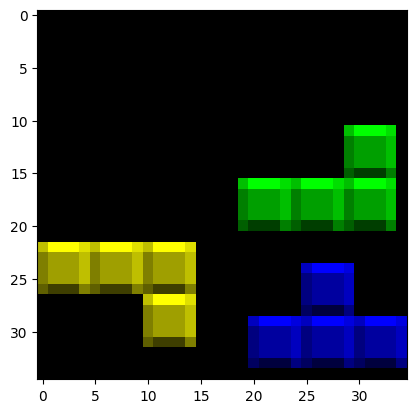

In [593]:
data_path = "/Users/kirkswanson/PyTorchPractice/data/tetrominoes.h5"

current_transforms = [
                # image has shape (H x W x C)
                transforms.ToTensor(),  # rescales to range [0.0, 1.0]
                # image has shape (C x H x W)
            ]
current_transforms.append(
                    transforms.Lambda(rescale)
                )  # rescale between -1 and 1
current_transforms.append(
    transforms.Resize(
        (35, 35), interpolation=transforms.InterpolationMode.NEAREST
    )
)
tetrominoes_transforms = transforms.Compose(current_transforms)

# dataset = TetrominoesDataset(data_path, tetrominoes_transforms=tetrominoes_transforms, mask_transforms=None)

train_dataset = TetrominoesDataset(
            data_root=data_path,
            tetrominoes_transforms=tetrominoes_transforms,
            mask_transforms=mask_transforms,
            split="train",
            max_n_objects=3,
)
val_dataset = TetrominoesDataset(
            data_root=data_path,
            tetrominoes_transforms=tetrominoes_transforms,
            mask_transforms=mask_transforms,
            split="val",
            max_n_objects=3,
)
image_translated = ((train_dataset[0] + 1) / 2) * 255
plt.imshow(image_translated.permute(1, 2, 0).int())

In [594]:
def build_grid(resolution):
    ranges = [torch.linspace(0., 1., steps=res) for res in resolution]
    grid = torch.stack(torch.meshgrid(*ranges, indexing="ij"), dim=-1)
    grid = grid.unsqueeze(0)  # Add batch dimension
    return torch.cat([grid, 1.0 - grid], dim=-1).to(device)

In [595]:
class SoftPositionEmbed(nn.Module):
    def __init__(self, hidden_size, resolution):
        super(SoftPositionEmbed, self).__init__()
        self.embedding = nn.Linear(4, hidden_size).to(device)
        self.grid = build_grid(resolution)

    def forward(self, inputs):
        grid = self.embedding(self.grid)
        return inputs + grid
        

In [596]:
class SlotAttention(nn.Module):
    def __init__(self, num_slots: int, dim: int, iters: int = 3, epsilon: float = 1e-8, hidden_size: int = 128):
        super(SlotAttention, self).__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.epsilon = epsilon
        self.scale = dim ** -0.5

        self.slots_mu = nn.Parameter(torch.randn(1, 1, dim)).to(device)
        self.slots_log_sigma = nn.Parameter(torch.randn(1, 1, dim)).to(device)

        self.project_q = nn.Linear(dim, dim).to(device)
        self.project_k = nn.Linear(dim, dim).to(device)
        self.project_v = nn.Linear(dim, dim).to(device)

        self.gru = nn.GRUCell(dim, dim).to(device)

        self.fc1 = nn.Linear(dim, hidden_size).to(device)
        self.fc2 = nn.Linear(hidden_size, dim).to(device)

        self.norm_input = nn.LayerNorm(dim).to(device)
        self.norm_slots = nn.LayerNorm(dim).to(device)
        self.norm_mlp = nn.LayerNorm(dim).to(device)

        self.slot_mlp = nn.Sequential(self.norm_mlp, self.fc1, nn.ReLU(), self.fc2).to(device)

    def forward(self, inputs: torch.tensor) -> torch.tensor: 
        B, N, D = inputs.shape

        mu = self.slots_mu.expand(B, self.num_slots, -1)
        sigma = torch.exp(self.slots_log_sigma.expand(B, self.num_slots, -1))
        slots = torch.normal(mu, sigma)

        inputs = self.norm_input(inputs)
        k, v = self.project_k(inputs), self.project_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots

            slots = self.norm_slots(slots)
            q = self.project_q(slots)

            attn = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = attn.softmax(dim=1) + self.epsilon
            attn = attn / attn.sum(dim=-1, keepdim=True)

            updates = torch.einsum('bjd,bij->bid', v, attn)

            slots = self.gru(
                updates.reshape(-1, D),
                slots_prev.reshape(-1, D),
            )

            slots = slots.reshape(B, -1, D)
            slots = slots + self.slot_mlp(slots)

        return slots

        

In [597]:
class Encoder(nn.Module):
    def __init__(self, resolution, hid_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hid_dim, 5, padding = 2).to(device)
        self.conv2 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2).to(device)
        self.conv3 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2).to(device)
        self.conv4 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2).to(device)
        self.encoder_pos = SoftPositionEmbed(hid_dim, resolution).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = x.permute(0,2,3,1)
        x = self.encoder_pos(x)
        x = torch.flatten(x, 1, 2)
        return x

In [617]:
x = torch.randn(32, 35, 35, 32).permute(0,3,1,2)
print(x.shape)
x = nn.ConvTranspose2d(32, 4, 3, stride=(1, 1), padding=1)(x)
print(x.shape)

torch.Size([32, 32, 35, 35])
torch.Size([32, 4, 35, 35])


In [618]:
class Decoder(nn.Module):
    def __init__(self, hid_dim, resolution):
        super().__init__()
        # self.conv1 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        # self.conv2 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        # self.conv3 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        # self.conv4 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        # self.conv5 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(1, 1), padding=2).to(device)
        # self.conv6 = nn.ConvTranspose2d(hid_dim, 4, 3, stride=(1, 1), padding=1).to(device)
        # self.decoder_initial_size = (8, 8)
        self.decoder_initial_size = (35, 35)
        self.conv1 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(1, 1), padding=2).to(device)
        self.conv2 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(1, 1), padding=2).to(device)
        self.conv3 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(1, 1), padding=2).to(device)
        self.conv4 = nn.ConvTranspose2d(hid_dim, 4, 3, stride=(1, 1), padding=1).to(device)
        self.decoder_pos = SoftPositionEmbed(hid_dim, self.decoder_initial_size).to(device)
        self.resolution = resolution

    def forward(self, x):
        x = self.decoder_pos(x)
        x = x.permute(0,3,1,2)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x = F.pad(x, (4,4,4,4)) # no longer needed
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        # x = self.conv5(x)
        # x = F.relu(x)
        # x = self.conv6(x)
        x = x[:,:,:self.resolution[0], :self.resolution[1]]
        x = x.permute(0,2,3,1)
        return x

In [619]:
class SlotAttentionAutoEncoder(nn.Module):
    def __init__(self, resolution, num_slots, num_iterations, hidden_size):
        super(SlotAttentionAutoEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.resolution = resolution
        self.num_slots = num_slots
        self.num_iterations = num_iterations

        self.encoder_cnn = Encoder(self.resolution, self.hidden_size)
        self.decoder_cnn = Decoder(self.hidden_size, self.resolution)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.slot_attention = SlotAttention(
            num_slots=self.num_slots,
            dim=self.hidden_size,
            iters = self.num_iterations,
            epsilon=1e-8, 
            hidden_size=128)
            
    def forward(self, image):
        x = self.encoder_cnn(image)
        x = nn.LayerNorm(x.shape[1:]).to(device)(x)  #TODO understand this shape input

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        slots = self.slot_attention(x)

        slots = slots.reshape((-1, slots.shape[-1])).unsqueeze(1).unsqueeze(2)
        slots = slots.repeat((1, 35, 35, 1))

        x = self.decoder_cnn(slots)

        recons, masks = x.reshape(image.shape[0], -1, x.shape[1], x.shape[2], x.shape[3]).split([3,1], dim=-1)

        # Normalize alpha masks over slots.
        masks = nn.Softmax(dim=1)(masks)
        recon_combined = torch.sum(recons * masks, dim=1)  # Recombine image.
        recon_combined = recon_combined.permute(0,3,1,2)
        # `recon_combined` has shape: [batch_size, width, height, num_channels].

        return recon_combined, recons, masks, slots

In [620]:
device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")

In [ ]:
model = SlotAttentionAutoEncoder(resolution=(35, 35), num_slots=4, num_iterations=3, hidden_size=32).to(device)
# dataset = ShapeDataset(IMAGE_SIZE, RADIUS, DATASET_SIZE)
warmup_steps = 10000
learning_rate = 0.0004
decay_rate = 0.5
decay_steps = 100000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_dataloader = DataLoader(
            train_dataset,
            batch_size=64,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            drop_last=True,
        )

val_dataloader = DataLoader(
            val_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            drop_last=True,
        )

# # Create the DataLoader instance
# train_size = int(0.8 * len(dataset))  
# test_size = len(dataset) - train_size  

# # Split the dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

i = 0
for epoch in range(1000):  
    model.train()
    train_loss = 0
    for batch_idx, image in tqdm(enumerate(train_dataloader)):
        i += 1

        optimizer.zero_grad() 

        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate

        learning_rate = learning_rate * (decay_rate ** (
            i / decay_steps))

        optimizer.param_groups[0]['lr'] = learning_rate

        image = image.to(device)
        recon_combined, recons, masks, slots = model(image)
        loss = criterion(recon_combined, image)   
        train_loss += loss

        del recons, masks, slots
 
        loss.backward()                    
        optimizer.step()
    
    test_loss = 0
    model.eval() 
    with torch.no_grad(): 
        for batch_idx, (image, mask, viz) in enumerate(val_dataloader):
            image = image.to(device)
            recon_combined, recons, masks, slots = model(image)
            loss = criterion(recon_combined, image)
            test_loss += loss
            del recons, masks, slots
    print(f"Epoch {epoch + 1}, Iterations {i}, Train Loss: {train_loss.item() / len(train_loader)}, Test Loss {test_loss.item() / len(test_loader)}")

156it [00:38,  4.06it/s]


Epoch 1, Iterations 156, Train Loss: 0.22137974039713543, Test Loss 0.02258460318788569


156it [00:38,  4.10it/s]


Epoch 2, Iterations 312, Train Loss: 0.22141048177083333, Test Loss 0.022615952694669685


156it [00:38,  4.09it/s]


Epoch 3, Iterations 468, Train Loss: 0.22137841796875, Test Loss 0.02260932262907637


156it [00:38,  4.08it/s]


Epoch 4, Iterations 624, Train Loss: 0.22144034830729167, Test Loss 0.022650368670199778


156it [00:38,  4.06it/s]


Epoch 5, Iterations 780, Train Loss: 0.22139310709635418, Test Loss 0.022631244456514397


156it [00:38,  4.09it/s]


Epoch 6, Iterations 936, Train Loss: 0.221384765625, Test Loss 0.022629319353306546


156it [00:39,  3.92it/s]


Epoch 7, Iterations 1092, Train Loss: 0.2213924357096354, Test Loss 0.022600430123349453


156it [00:44,  3.53it/s]


Epoch 8, Iterations 1248, Train Loss: 0.2214404093424479, Test Loss 0.022622341805316033


156it [00:43,  3.61it/s]


Epoch 9, Iterations 1404, Train Loss: 0.22141560872395832, Test Loss 0.022605053921963308


156it [00:42,  3.63it/s]


Epoch 10, Iterations 1560, Train Loss: 0.22139290364583333, Test Loss 0.02261278477120907


156it [00:43,  3.62it/s]


Epoch 11, Iterations 1716, Train Loss: 0.22139896647135418, Test Loss 0.022673599263455007


156it [00:43,  3.62it/s]


Epoch 12, Iterations 1872, Train Loss: 0.22136421712239585, Test Loss 0.02259595343407164


156it [00:43,  3.59it/s]


Epoch 13, Iterations 2028, Train Loss: 0.22136824544270833, Test Loss 0.022615592530433166


156it [00:43,  3.58it/s]


Epoch 14, Iterations 2184, Train Loss: 0.22141725667317708, Test Loss 0.02261187421514633


156it [00:43,  3.57it/s]


Epoch 15, Iterations 2340, Train Loss: 0.22138800048828125, Test Loss 0.022642518611664466


156it [00:44,  3.50it/s]


Epoch 16, Iterations 2496, Train Loss: 0.22139479573567708, Test Loss 0.02261855754446476


156it [00:44,  3.53it/s]


Epoch 17, Iterations 2652, Train Loss: 0.22136494954427083, Test Loss 0.022642739275668528


156it [00:43,  3.55it/s]


Epoch 18, Iterations 2808, Train Loss: 0.22148899332682292, Test Loss 0.022634567098414646


156it [00:44,  3.54it/s]


Epoch 19, Iterations 2964, Train Loss: 0.22146931966145833, Test Loss 0.02263412577040652


156it [00:44,  3.51it/s]


Epoch 20, Iterations 3120, Train Loss: 0.22140175374348958, Test Loss 0.022663895120012


156it [00:44,  3.51it/s]


Epoch 21, Iterations 3276, Train Loss: 0.22141377766927084, Test Loss 0.02262067033889446


156it [00:44,  3.53it/s]


Epoch 22, Iterations 3432, Train Loss: 0.22137650553385416, Test Loss 0.02263091980142796


156it [16:04,  6.18s/it]


Epoch 23, Iterations 3588, Train Loss: 0.22135882568359375, Test Loss 0.02263415367045301


156it [00:57,  2.72it/s]


Epoch 24, Iterations 3744, Train Loss: 0.2213800048828125, Test Loss 0.022627102567794474


143it [00:35,  4.09it/s]

In [ ]:
num_slots = 4
image = train_dataset[0]
x = test_image.permute(1, 2, 0).detach().numpy()
plt.imshow(x)
recon_combined, recons, masks, slots = model(image.unsqueeze(0))

import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
fig, ax = plt.subplots(1, 2 + num_slots, figsize=(15, 2))
image = image.squeeze(0)
recon_combined = recon_combined.squeeze(0)
recons = recons.squeeze(0)
masks = masks.squeeze(0)
image = image.permute(1,2,0).cpu().numpy()
recon_combined = recon_combined.permute(1,2,0)
recon_combined = recon_combined.cpu().detach().numpy()
recons = recons.cpu().detach().numpy()
masks = masks.cpu().detach().numpy()
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined.astype(int))
ax[1].set_title('Recon.')
for i in range(4):
  picture = recons[i] * masks[i] + (1 - masks[i])
  ax[i + 2].imshow(picture.astype(int))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')

In [249]:
model = SlotAttentionAutoEncoder(resolution=(80, 80), num_slots=2, num_iterations=3, hidden_size=64)
dataset = ShapeDataset(IMAGE_SIZE, RADIUS, DATASET_SIZE)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Create the DataLoader instance
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # The rest for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for epoch in range(20):  # Example: 5 epochs
# Iterate through the data loader (for example, in a training loop)
    train_loss = 0
    for batch_idx, (data, labels) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()               # Clear gradients
        output_logits = model(data)        # Forward pass
        # Loss for slot 1 = square, slot 2 = circle
        loss = 0
        for i in range(len(output_logits)):
            loss_v1 = criterion(output_logits[i][0], labels[i][0]) + criterion(output_logits[i][1], labels[i][1])
            loss_v2 = criterion(output_logits[i][0], labels[i][1]) + criterion(output_logits[i][1], labels[i][0])
            loss = loss + min(loss_v1, loss_v2)
        loss.backward()                     # Backward pass
        optimizer.step()
        train_loss += loss
    test_loss = 0
    with torch.no_grad(): 
        for batch_idx, (data, labels) in enumerate(test_loader):
            output_logits = model(data)        # Forward pass
            for i in range(len(output_logits)):
                loss_v1 = criterion(output_logits[i][0], labels[i][0]) + criterion(output_logits[i][1], labels[i][1])
                loss_v2 = criterion(output_logits[i][0], labels[i][1]) + criterion(output_logits[i][1], labels[i][0])
                test_loss += min(loss_v1, loss_v2)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss.item() / len(train_loader)}, Test Loss {test_loss.item() / len(test_loader)}")

0it [00:00, ?it/s]

KIRK torch.Size([32, 80, 80, 4])
KIRK torch.Size([16, 2, 80, 80, 3]) torch.Size([16, 2, 80, 80, 1])


ValueError: Target size (torch.Size([])) must be the same as input size (torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


tensor([[0.9999, 0.0038]], grad_fn=<SigmoidBackward0>)


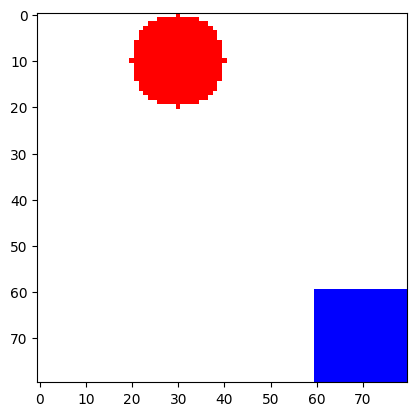

In [166]:
test_image, test_label = train_dataset[0]
x = test_image.permute(1, 2, 0).detach().numpy()
plt.imshow(x)
test_label
output_logits = model(test_image.unsqueeze(0))  # Forward pass
print(nn.Sigmoid()(output_logits))

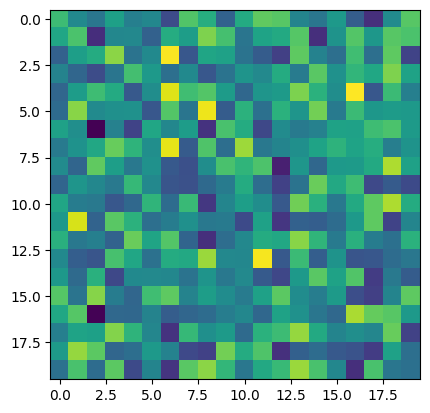

In [130]:
plt.imshow(attn_logits.reshape(20, 20, 2)[:, :, 1])

In [845]:
test_image, test_label = test_dataset[1500]
test_image = test_image.unsqueeze(0)
# model = Model()
# output = model(test_image.unsqueeze(0))


# Convolutional Layer 1: Input channels = 3 (e.g., color image), Output channels = 16
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

# Convolutional Layer 2: Input channels = 16, Output channels = 32
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
positional_embedding = nn.Parameter(torch.randn(1, 32, 10, 10))

# Pooling layer
pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Slots
slots = nn.Parameter(torch.normal(mean=0, std=1, size=(2, 32)))
input_layer_norm = nn.LayerNorm(32)
slot_layer_norm = nn.LayerNorm(32)
slot_mlp_layer = nn.Linear(in_features=32, out_features=32)


# Embedding layers
k_embed = nn.Linear(in_features=32, out_features=32)
v_embed = nn.Linear(in_features=32, out_features=32)
q_embed = nn.Linear(in_features=32, out_features=32)
gru = nn.GRUCell(32, 32)

final_mlp_layer = nn.Linear(in_features=32, out_features=2)

inputs = pool(conv2(pool(conv1(test_image)))) + positional_embedding
inputs = input_layer_norm(k_embed(inputs.reshape(x.shape[0], -1, inputs.shape[1])))
slots = q_embed(slots)
slots = slots.unsqueeze(0).repeat(inputs.shape[0], 1, 1)  # [B, S, D]

for _ in range(3): 
    prev_slots = slots  # [B, S, D]
    slots = slot_layer_norm(slots).permute(0, 2, 1)  # [B, D, S]
    attn = F.softmax(torch.bmm(inputs, slots)*1./math.sqrt(32), dim=-1)
    attn = attn / attn.sum(dim=1)
    attn = attn.permute(0, 2, 1)
    values = v_embed(inputs)
    updates = torch.bmm(attn, values)  # [B, S, D]
    updated_slots = []
    for i in range(updates.shape[1]):
        updated_slots.append(gru(updates[:, i, :], prev_slots[:, i, :]).unsqueeze(1))
    updated_slots = torch.cat(updated_slots, dim=1)
    updated_slots = slot_layer_norm(updated_slots)
    slots = slot_mlp_layer(updated_slots)

outputs = final_mlp_layer(slots)

In [846]:
outputs.shape

torch.Size([1, 2, 2])

In [817]:
updated_slots = []
for i in range(updates.shape[1]):
    updated_slots.append(gru(updates[:, i, :], prev_slots[:, i, :]).unsqueeze(1))
updated_slots = torch.cat(updated_slots, dim=1)

In [818]:
updated_slots.shape

torch.Size([5, 2, 32])

In [759]:
updated_slot.shape

torch.Size([1, 32])